# Crop Price Prediction using LSTM

This notebook demonstrates how to build and train an LSTM (Long Short-Term Memory) model to predict the modal price of bananas based on historical data. The process includes data loading, preprocessing, model training, evaluation, and making predictions for a specific date.

## 1. Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## 2. Load and Preprocess the Data

In [2]:
# Load the dataset
# IMPORTANT: Make sure the 'Banana.csv' file is in the same directory as this notebook
# or provide the correct path to the file.
try:
    df = pd.read_csv('../Weather_Merged_CSVs/Banana.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Banana.csv' not found. Please ensure the file is in the correct directory.")
    # As a fallback for demonstration, creating a dummy dataframe.
    # Replace this with your actual data loading.
    data = {'District Name': ['Dharmapuri'], 'Market Name': ['AJattihalli(Farmers Market)'],
            'Commodity': ['Banana'], 'Variety': ['Besrai'], 'Grade': ['Local'],
            'Min Price (Rs./Quintal)': [4000.0], 'Max Price (Rs./Quintal)': [4500.0],
            'Modal Price (Rs./Quintal)': [4500.0], 'Price Date': ['2025-06-18'],
            'Day Of Week': [2], 'lookback_temp_mean': [27.77], 'lookback_precip_sum': [258.2]}
    df = pd.DataFrame(data)


# Convert 'Price Date' to datetime objects and set as index
df['Price Date'] = pd.to_datetime(df['Price Date'])
df.sort_values('Price Date', inplace=True)
df.set_index('Price Date', inplace=True)

# Display the first few rows
print("Original Data:")
print(df.head())

Data loaded successfully.
Original Data:
           District Name  Market Name Commodity Variety   Grade  \
Price Date                                                        
2016-04-30    Coimbatore        Sulur    Banana   Other   Large   
2018-05-07    Coimbatore        Sulur    Banana   Other   Large   
2018-09-20         Theni  Chinnamanur    Banana  Poovan  Medium   
2018-09-27         Theni  Chinnamanur    Banana  Poovan  Medium   
2018-10-12         Theni  Chinnamanur    Banana   Other  Medium   

            Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
Price Date                                                     
2016-04-30                   1200.0                   1400.0   
2018-05-07                   3200.0                   3400.0   
2018-09-20                   1300.0                   1600.0   
2018-09-27                   1300.0                   1600.0   
2018-10-12                   1200.0                   1400.0   

            Modal Price (Rs./Quintal)  D

In [3]:
# Encode categorical features
categorical_cols = ['District Name', 'Market Name', 'Commodity', 'Variety', 'Grade']
encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = encoders[col].fit_transform(df[col])

print("\nData after Label Encoding:")
print(df.head())


Data after Label Encoding:
            District Name  Market Name  Commodity  Variety  Grade  \
Price Date                                                          
2016-04-30              2          191          0        1      0   
2018-05-07              2          191          0        1      0   
2018-09-20             24           32          0        2      2   
2018-09-27             24           32          0        2      2   
2018-10-12             24           32          0        1      2   

            Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
Price Date                                                     
2016-04-30                   1200.0                   1400.0   
2018-05-07                   3200.0                   3400.0   
2018-09-20                   1300.0                   1600.0   
2018-09-27                   1300.0                   1600.0   
2018-10-12                   1200.0                   1400.0   

            Modal Price (Rs./Quintal)  

In [4]:
# Feature Scaling
# We will scale the numerical features to be between 0 and 1
scaler = MinMaxScaler()
target_scaler = MinMaxScaler() # Separate scaler for the target variable

# We'll use all columns as features for prediction
features = df.columns
df_scaled = scaler.fit_transform(df[features])

# Fit the target scaler on the 'Modal Price' column for inverse transforming later
modal_price_index = df.columns.get_loc('Modal Price (Rs./Quintal)')
target_scaler.fit(df[['Modal Price (Rs./Quintal)']])

# Create a new DataFrame with scaled values
df_scaled = pd.DataFrame(df_scaled, columns=features, index=df.index)

print("\nData after Scaling:")
print(df_scaled.head())


Data after Scaling:
            District Name  Market Name  Commodity   Variety     Grade  \
Price Date                                                              
2016-04-30       0.057143     0.795833        0.0  0.333333  0.000000   
2018-05-07       0.057143     0.795833        0.0  0.333333  0.000000   
2018-09-20       0.685714     0.133333        0.0  0.666667  0.666667   
2018-09-27       0.685714     0.133333        0.0  0.666667  0.666667   
2018-10-12       0.685714     0.133333        0.0  0.333333  0.666667   

            Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
Price Date                                                     
2016-04-30                 0.047428                 0.013803   
2018-05-07                 0.127476                 0.033807   
2018-09-20                 0.051431                 0.015803   
2018-09-27                 0.051431                 0.015803   
2018-10-12                 0.047428                 0.013803   

            Modal 

## 3. Create Time-Series Sequences

LSTM models require input data in the form of sequences. We will create sequences of a fixed length (lookback period) to predict the next time step's price.

In [5]:
def create_sequences(data, lookback, target_col_index):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        y.append(data[i + lookback, target_col_index])
    return np.array(X), np.array(y)

# Define the lookback period
lookback = 120 # Use 120 days of data to predict the next day's price

# Create sequences
X, y = create_sequences(df_scaled.values, lookback, modal_price_index)

print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (56979, 120, 11)
Shape of y: (56979,)


## 4. Split Data and Create DataLoaders

In [6]:
# Split the data into training and testing sets (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train shape: (45583, 120, 11), y_train shape: (45583,)
X_test shape: (11396, 120, 11), y_test shape: (11396,)


## 5. Define the LSTM Model

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer to get the final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))

        # We only want the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = X_train.shape[2] # Number of features
hidden_size = 500  # Increased hidden size
num_layers = 3     # Increased number of layers
output_size = 1

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.3).to(device)
print(model)

Using device: cuda
LSTMModel(
  (lstm): LSTM(11, 500, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


## 6. Train the Model

In [8]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Lower learning rate

# Training loop
num_epochs = 30  # Increased epochs
batch_size = 32  # Reduced batch size for more updates
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (sequences, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}')

Epoch [1/30], Loss: 0.000412
Epoch [2/30], Loss: 0.000364
Epoch [3/30], Loss: 0.000342
Epoch [4/30], Loss: 0.000338
Epoch [5/30], Loss: 0.000336
Epoch [6/30], Loss: 0.000335
Epoch [7/30], Loss: 0.000335
Epoch [8/30], Loss: 0.000334
Epoch [9/30], Loss: 0.000334
Epoch [10/30], Loss: 0.000334
Epoch [11/30], Loss: 0.000334
Epoch [12/30], Loss: 0.000334
Epoch [13/30], Loss: 0.000333
Epoch [14/30], Loss: 0.000333
Epoch [15/30], Loss: 0.000333
Epoch [16/30], Loss: 0.000333
Epoch [17/30], Loss: 0.000333
Epoch [18/30], Loss: 0.000333
Epoch [19/30], Loss: 0.000332
Epoch [20/30], Loss: 0.000341
Epoch [21/30], Loss: 0.000333
Epoch [22/30], Loss: 0.000332
Epoch [23/30], Loss: 0.000332
Epoch [24/30], Loss: 0.000332
Epoch [25/30], Loss: 0.000332
Epoch [26/30], Loss: 0.000332
Epoch [27/30], Loss: 0.000332
Epoch [28/30], Loss: 0.000332
Epoch [29/30], Loss: 0.000333
Epoch [30/30], Loss: 0.000332


## 7. Evaluate the Model

In [9]:
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for sequences, labels in test_loader:
        # Move tensors to the configured device
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = model(sequences)
        all_predictions.append(outputs.cpu().numpy()) # Move predictions to CPU for numpy conversion
        all_actuals.append(labels.cpu().numpy()) # Move labels to CPU for numpy conversion

# Concatenate all batches
predictions_scaled = np.concatenate(all_predictions)
actuals_scaled = np.concatenate(all_actuals)

# Inverse transform the predictions and actuals to get original price values
predictions = target_scaler.inverse_transform(predictions_scaled)
actuals = target_scaler.inverse_transform(actuals_scaled)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
# Calculate percentage accuracy
mean_actual = np.mean(actuals)
accuracy = 100 * (1 - (rmse / mean_actual))
print(f'\nTest Root Mean Squared Error (RMSE): {rmse:.2f} Rs./Quintal')
print(f'Model Percentage Accuracy: {accuracy:.2f}%')


Test Root Mean Squared Error (RMSE): 1617.32 Rs./Quintal
Model Percentage Accuracy: 71.25%


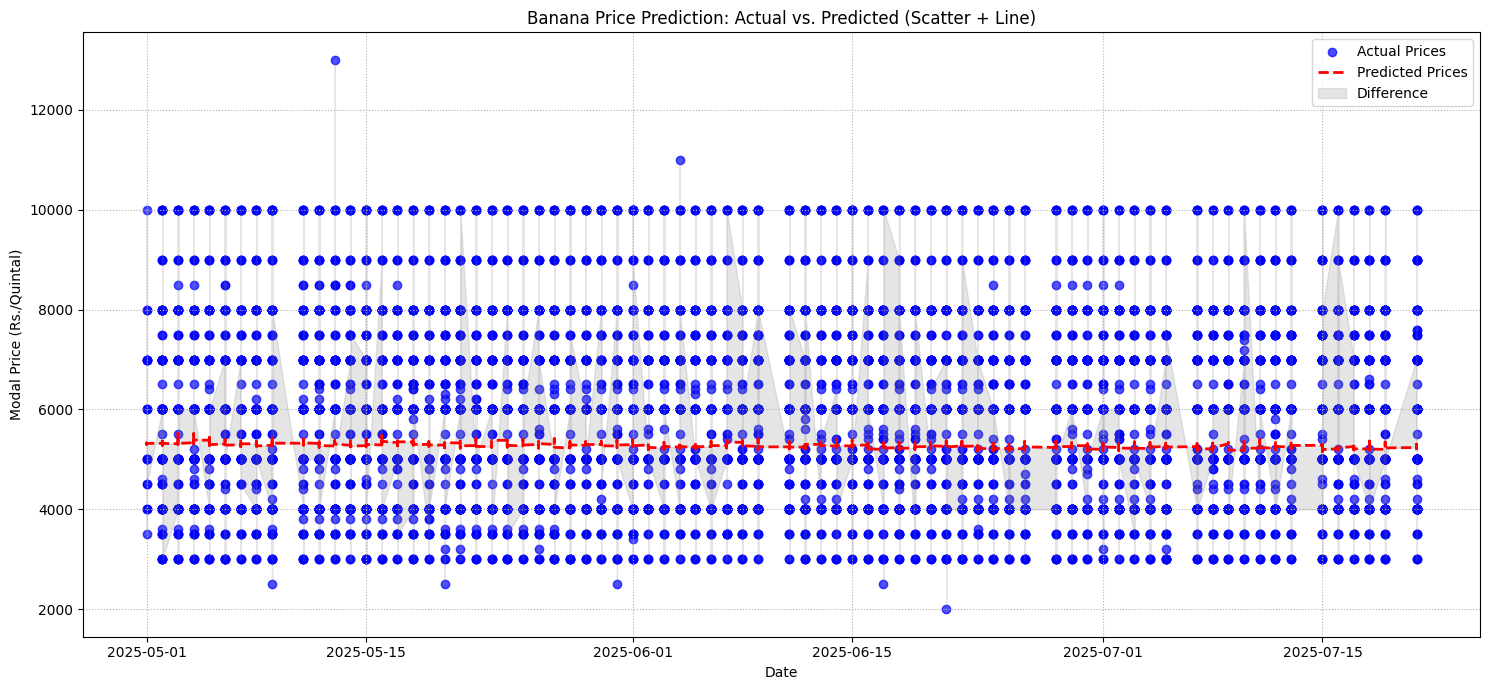

In [10]:
# Get the dates corresponding to the test set
test_dates = df.index[split_index + lookback:]

plt.figure(figsize=(15, 7))
plt.scatter(test_dates, actuals, label='Actual Prices', color='blue', marker='o', alpha=0.7)
plt.plot(test_dates, predictions, label='Predicted Prices', color='red', linestyle='--', linewidth=2)
plt.fill_between(test_dates, np.squeeze(predictions), np.squeeze(actuals), color='gray', alpha=0.2, label='Difference')
plt.title('Banana Price Prediction: Actual vs. Predicted (Scatter + Line)')
plt.xlabel('Date')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

## 9. Predict Price for a Specific Date

In [11]:
def predict_price(target_date_str):
    """
    Predicts the modal price for a given date.
    The function requires the `lookback` period of historical data before the target date.
    """
    try:
        target_date = datetime.strptime(target_date_str, '%Y-%m-%d')
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."

    # Find the end date for the required historical data
    end_date = target_date - timedelta(days=1)
    start_date = end_date - timedelta(days=lookback - 1)

    # Get the last 'lookback' days of data from our original dataframe
    # We use the original df to get the data before scaling
    last_sequence_df = df.loc[start_date:end_date]

    if len(last_sequence_df) < lookback:
        return f"Not enough historical data to predict for {target_date_str}. Required {lookback} days, found {len(last_sequence_df)}."

    # Ensure we have exactly 'lookback' days
    last_sequence_df = last_sequence_df.tail(lookback)

    # Scale the sequence
    last_sequence_scaled = scaler.transform(last_sequence_df)

    # Convert to tensor, add batch dimension, and move to the device
    sequence_tensor = torch.tensor(last_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction_scaled = model(sequence_tensor)

    # Inverse transform the prediction (move to CPU for numpy conversion)
    predicted_price = target_scaler.inverse_transform(prediction_scaled.cpu().numpy())

    return f"Predicted Modal Price for {target_date_str}: {predicted_price[0][0]:.2f} Rs./Quintal"

# Example: Predict price for a date
# Note: The date must be after the available historical data allows.
# Let's try to predict the day after our last known data point.
last_date_in_data = df.index.max()
prediction_date = (last_date_in_data + timedelta(days=1)).strftime('%Y-%m-%d')

print(predict_price('2025-07-01'))
print(predict_price('2025-09-15'))

Predicted Modal Price for 2025-07-01: 5202.77 Rs./Quintal
Predicted Modal Price for 2025-09-15: 5212.11 Rs./Quintal
